# Tech Challenger - Fase 01 - Etapa 02 - Contrução do Modelo

Nessa fase vamos captar o que foi feito e escolhido de processamento durante a etapa anterior e vamos a partir disso escolher o modelo.
Nessa etapa podemos até mesmo modificar alguma etapa do pre processamento para melhor ajustar a taxa de acerto.

## Compilando a leitura e processamento da etapa anterior

Unificando o que foi explicado na etapa anterior em um código limp para apenas processar os dados.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

data = pd.read_csv("dados/insurance.csv")

data = data.drop(['region'], axis=1)  # A Coluna Região não é relevante para o modelo

# Removendo Outliers
for column in ['bmi', 'age']:
    Q1, Q3 = np.percentile(data[column], [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    data_encoded = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


data['bmi_obesidade'] = data['bmi'] >= 30
data['bmi_obesidade_label'] = data['bmi_obesidade'].replace({True: "obese", False: 'not obese'})
data['smoker_bmi_group'] = data['smoker'] + ' / ' + data['bmi_obesidade_label']

# Criando um pré-processador para normalizar os dados numericos e categoricos
categorical_columns = ['sex', 'smoker', 'bmi_obesidade_label', 'smoker_bmi_group']

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('cat', OneHotEncoder(), categorical_columns)  # categorical features
#    ]
#)
#base_transformed = preprocessor.fit_transform(data)
#base_transformed_df = pd.DataFrame(base_transformed, columns=preprocessor.get_feature_names_out())
#data_encoded = pd.concat([data.drop(columns=categorical_columns), base_transformed_df], axis=1)


label_encoder = LabelEncoder() # Trocanode One-Hot Enconder temos uma melhora de 0.01 no R2
for col in  categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

    
data.head()

Original DataFrame Shape: (1338, 7)
DataFrame Shape after Removing Outliers: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


## Construção do Modelo

Nessa etapa vamos dividir os dados de teste e treinamento e escolher os modelos que podemos utilizar para previsão.

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [65]:
# Dividir os dados em conjuntos de treinamento e teste
from sklearn.preprocessing import StandardScaler


X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

scaler = StandardScaler()
scaler.fit(X_train)
x_train_escalonado = scaler.transform(X_train)
x_test_escalonado = scaler.transform(X_test)



Como avaliar o que está bom ou ruim:
* MSE e MAE:
    * Compare os valores entre os modelos. O modelo com os menores valores de MSE e MAE é o mais preciso.
    * Se os valores forem muito altos, o modelo pode estar subajustado (underfitting).
* R²:
    * Um valor próximo de 1 é desejável.
    * Se o R² for muito baixo, o modelo pode não estar capturando bem os padrões dos dados.
    * Se for muito alto, verifique se o modelo não está superajustado (overfitting).
* QQ Plot:
    * Resíduos alinhados indicam que o modelo está atendendo à suposição de normalidade.
    * Se houver desvios, considere ajustar o modelo ou revisar os dados.

Modelo:  LinearRegression()
Mean Squared Error (MSE):  35438946.806484185
Mean Absolute Error (MAE):  4212.007042774464
R-squared (R2):  0.7108458825049928


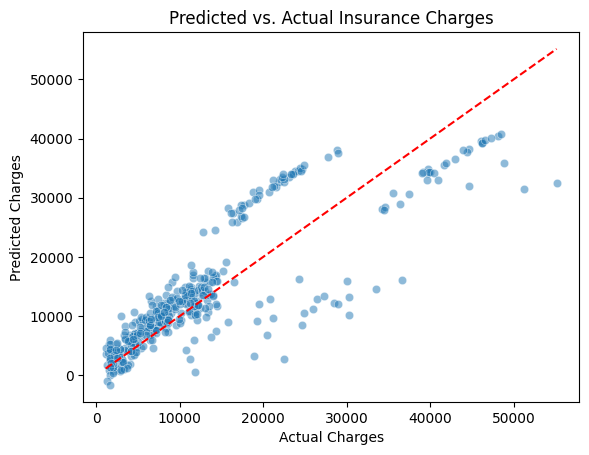

-------------------
Modelo:  DecisionTreeRegressor()
Mean Squared Error (MSE):  37385418.20446528
Mean Absolute Error (MAE):  2795.0376803482586
R-squared (R2):  0.6949641966753926


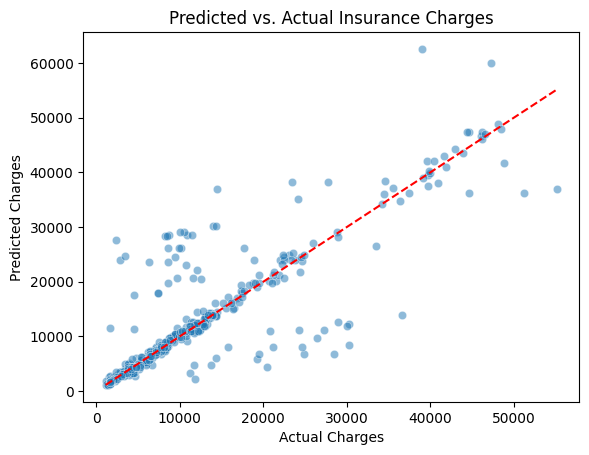

-------------------
Modelo:  RandomForestRegressor()
Mean Squared Error (MSE):  20924613.466358762
Mean Absolute Error (MAE):  2695.878858523869
R-squared (R2):  0.829271502513103


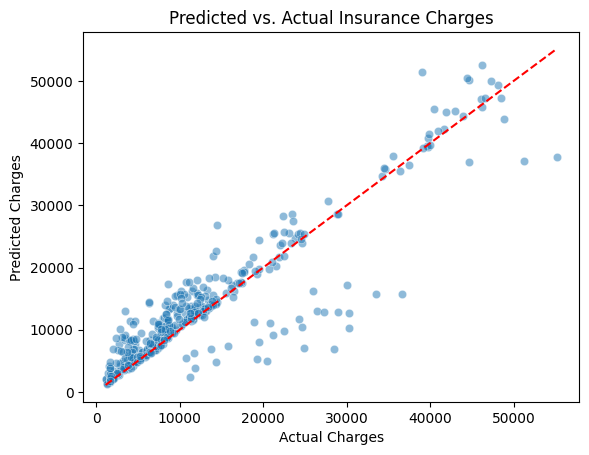

-------------------
Modelo:  KNeighborsRegressor()
Mean Squared Error (MSE):  26871411.668118965
Mean Absolute Error (MAE):  3117.4176994721397
R-squared (R2):  0.7807502754196317


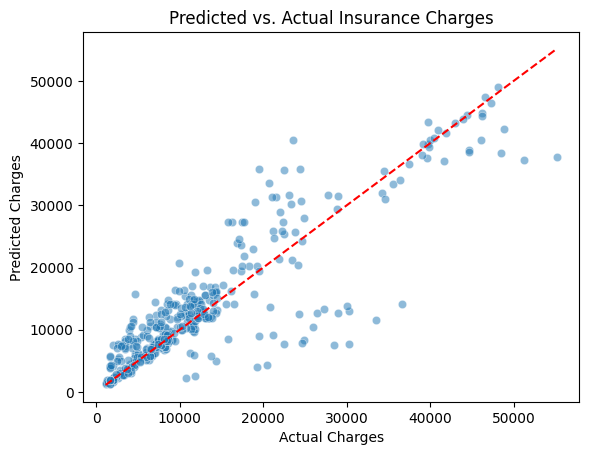

-------------------


In [66]:
# Selecionando alguns modelos e verificando o desempenho
models = [
    LinearRegression(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(n_estimators=100),
    KNeighborsRegressor(n_neighbors=5)
]

for model in models:
    model.fit(x_train_escalonado, y_train)
    y_pred = model.predict(x_test_escalonado)
    residuals = y_test - y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Modelo: ", model)
    print('Mean Squared Error (MSE): ', mse)
    print('Mean Absolute Error (MAE): ', mae)
    print('R-squared (R2): ', r2)
    
    # Criando um DataFrame para armazenar os valores reais e previstos
    results = pd.DataFrame({
        "Actual Charges": y_test,
        "Predicted Charges": y_pred
    })
    
    sns.scatterplot(data=results, x="Actual Charges", y="Predicted Charges", alpha=0.5)
    plt.plot(
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        [results["Actual Charges"].min(), results["Actual Charges"].max()],
        color='red',
        linestyle='--'
    )
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title("Predicted vs. Actual Insurance Charges")
    plt.show()
    print('-------------------')